In [126]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import time
from keras import backend as K
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
#from multiprocessing import Pool,cpu_count
import sklearn.metrics as m
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [75]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''
'r'
def plot_test(y_test,y_pred,start,end):
    #Plot of testing.
    plt.figure(figsize=(10,10))
    plt.plot(y_test[start:end],'r')
    plt.plot(y_pred[start+1:end],'b')
    plt.xticks(np.arange(0,end-start,1))
    plt.legend()
    plt.show()

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_pred - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_df(localdf):
    i=0
    newdf = []
    timestamp = []
    d = np.zeros((7,))
    newhr = []
    while(24*(i+1)<localdf.shape[0]):
        #print (np.shape(np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1)),np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1))
        d = np.sum(localdf.values[24*i:24*(i+1),1:],axis=0)
        newhr.append(localdf.values[24*i:24*(i+1),-1])
        timestamp.append(localdf.values[24*i,0])
        newdf.append(d.T)
        i += 1
    
    print ("End i: ",i)
    newdf = np.hstack((np.reshape(timestamp,(-1,1)),newdf))
    print (newdf)
    return newdf,newhr
  


def nn_model(localdf,localdict,times,metric,num_cols,hour_day):
    for counter in range(times):
            #i = num_cols
        #for i in range(num_cols):
            i=num_cols
            df = pd.DataFrame()
            if(i != 0):
                print(localdf.columns[i])
                df = localdf[localdf.columns[i]]
                
                #ndf = pd.concat([df.shift(24),df.shift(23),df.shift(22),df.shift(21),df.shift(20),df.shift(19),df.shift(18),df.shift(17),df.shift(16),df.shift(15),df.shift(14),df.shift(13),df.shift(12),df.shift(11),df.shift(10),df.shift(9),df.shift(8),df.shift(7),df.shift(6),df.shift(5),df.shift(4),df.shift(3),df.shift(2), df.shift(1), df], axis=1)
                #ndf.columns = ('t-24','t-23','t-22','t-21','t-20','t-19','t-18','t-17','t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1','t')
                #ndf = ndf.iloc[24:]
                #hour_day = hour_day.iloc[24:]
                #print (ndf.head())
                #print (ndf.tail())
                #print (ndf.columns)
                
                #Function returns Day loads and total load also separately
                ndf,nhr = create_df(localdf)
                ndf = pd.DataFrame(ndf,columns = localdf.columns)
                #To get the total load of the days
                df = pd.DataFrame(ndf.values[:,-1])
                # To collate d1 to d7
                ndf = pd.concat([df.shift(7),df.shift(6),df.shift(5),df.shift(4),df.shift(3),df.shift(2),df.shift(1),df.shift(0)],axis=1)
                ndf.columns = ('t-7','t-6','t-5','t-4','t-3','t-2','t-1','t')
                print ("mean :",ndf['t'].mean(),"max:",ndf['t'].max(),"min:",ndf['t'].min())
                
                #Creating a df for input and ground truth
                '''newdata = pd.DataFrame(np.hstack((nhr,ndf)))
                newop = ndf.values[:,1]
                '''
                x = ndf.values[7:,:-1]#np.hstack((ndf.values[7:-1],nhr[7:-1]))
                y = ndf.values[7:,-1]
                
                print (x.shape,y.shape)
                #ndf = pd.concat([ndf,hour_day],axis=1)
                #x = pd.concat([x,hour_day],axis=1)
                #print ("\n",y.shape)
                #x = ndf[ndf.columns[0:24]]
                #print (x.shape)
                #print (y.shape)
                print (ndf.describe())
                #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
                train_size = int(x.shape[0]*0.7)
                X_train = x[:train_size]
                y_train = y[:train_size]
                    
                X_test = x[train_size:]
                y_test = y[train_size:]
                print ("Split done ",X_train.shape,X_test.shape,y_train.shape,y_test.shape,)
                model=ExtraTreesRegressor(n_estimators=200,verbose=1)
                model.fit(X_train,y_train)
#                 model = Sequential()
#                 model.add(Dense(15,input_dim=7,kernel_initializer='normal', activation='relu'))
#                 #Output Layer.
#                 model.add(Dense(1,kernel_initializer='normal'))
#                 #Compile model.
#                 model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
#                 #Fit the model.
#                 history = model.fit(X_train,y_train,epochs=2000,batch_size=32,verbose=1)
#                 #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = 0#model.evaluate(X_test,y_test,verbose=1)
                y_pred = model.predict(X_test)
                
                y_pred[y_pred<0]=0
                
                print ("R2 Score : ",r2_score(y_test,y_pred))
                print ("MSE : ",mean_squared_error(y_test[:-1],y_pred[1:]))
                print ("MAE : ",mean_absolute_error(y_test[:-1],y_pred[1:]))
                
                #print (str(coeff_determination(y_test,y_pred)))
#               print ("Metric : %.5f" % (scores[1]))
                localdict["R2"] = r2_score(y_test,y_pred)
                localdict["MSE"] = mean_squared_error(y_test,y_pred)
                localdict["MAE"] = mean_absolute_error(y_test,y_pred)       
                #model.summary()
                
                plot_test(y_test,y_pred,0,50)
    return localdict,y_test,y_pred  

In [76]:
df= pd.read_pickle("../DataSets/New_Pecan_Street/load_data_1632.pkl")
df_new=df

In [77]:
pos=[]
for i in range(3,len(df.columns)):
    if (np.sum(np.isnan(df.iloc[:,i].values))>=40995):
        print ('Empty Column')
        pos.append(i)
    else:
        print ('All fine')
        

All fine
All fine
All fine
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column


In [78]:
df_new.drop(df_new.columns[pos], inplace=True, axis=1)

In [79]:
for i in range(3,len(df.columns)):
    print (df.columns[i], np.sum(np.isnan(df.iloc[:,i].values)))

air1 1
air2 1
air3 18
bathroom1 18
clotheswasher1 0
dishwasher1 0
disposal1 0
drye1 40833
dryg1 162
furnace1 18
furnace2 0
garage1 18
garage2 162
grid 1
kitchenapp1 0
kitchenapp2 0
lights_plugs1 18
lights_plugs2 18
lights_plugs3 40851
microwave1 0
outsidelights_plugs1 1
outsidelights_plugs2 1
range1 40851
refrigerator1 7942
waterheater1 18


In [80]:
nuls={}
l=0
for i in range(3,len(df.columns)):
    a=df.iloc[:,i].values
    b=[]
    for j in range (len(a)):
        if np.isnan(a[j])==1:
            b.append(j)
    string = str(i)+"-"+str(np.sum(np.isnan(a)))
    nuls[string]=b


In [81]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                      0
localhour                   0
use                         1
air1                        1
air2                        1
air3                       18
bathroom1                  18
clotheswasher1              0
dishwasher1                 0
disposal1                   0
drye1                   40833
dryg1                     162
furnace1                   18
furnace2                    0
garage1                    18
garage2                   162
grid                        1
kitchenapp1                 0
kitchenapp2                 0
lights_plugs1              18
lights_plugs2              18
lights_plugs3           40851
microwave1                  0
outsidelights_plugs1        1
outsidelights_plugs2        1
range1                  40851
refrigerator1            7942
waterheater1               18
dtype: int64

In [82]:
#Dropping the columns : (1) drye1 (2) lights_plugs3 (3)range1 
df.drop(df.columns[[10,21,25]],inplace=True,axis=1)

In [83]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                     0
localhour                  0
use                        1
air1                       1
air2                       1
air3                      18
bathroom1                 18
clotheswasher1             0
dishwasher1                0
disposal1                  0
dryg1                    162
furnace1                  18
furnace2                   0
garage1                   18
garage2                  162
grid                       1
kitchenapp1                0
kitchenapp2                0
lights_plugs1             18
lights_plugs2             18
microwave1                 0
outsidelights_plugs1       1
outsidelights_plugs2       1
refrigerator1           7942
waterheater1              18
dtype: int64

In [84]:
df_thermal = df[['dataid','localhour','air1','air2','air3','furnace1','furnace2','waterheater1']]
#Removing the dataid and the localhour column from df_thermal.
del df_thermal[df_thermal.columns[0]]
print (df_thermal.shape)

(40995, 7)


In [85]:
df_thermal.isnull().sum()

localhour        0
air1             1
air2             1
air3            18
furnace1        18
furnace2         0
waterheater1    18
dtype: int64

In [86]:
df_thermal = pd.DataFrame(df_thermal.values[175:],columns=df_thermal.columns)

In [87]:
df_thermal.isnull().sum()

localhour       0
air1            1
air2            1
air3            0
furnace1        0
furnace2        0
waterheater1    0
dtype: int64

In [88]:
print( df_thermal.iloc[34491:34494])
df_thermal.values[34492][1] = (df_thermal.iloc[34492-24*7+1][1] + df_thermal.iloc[34492+24*7+1][1]) / 2
df_thermal.values[34492][2] = (df_thermal.iloc[34292-24*7+1][2] + df_thermal.iloc[34492+24*7+1][2]) / 2
print(df_thermal.iloc[34316-24*7+1],df_thermal.iloc[34316+24*7+1])

                    localhour air1         air2 air3 furnace1 furnace2  \
34491  2017-02-27 10:00:00-06    0  6.66667e-05    0    0.005    0.005   
34492  2017-02-27 11:00:00-06  NaN          NaN    0    0.005    0.005   
34493  2017-02-27 12:00:00-06    0            0    0    0.005    0.005   

      waterheater1  
34491            0  
34492            0  
34493            0  
localhour       2017-02-13 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34149, dtype: object localhour       2017-02-27 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34485, dtype: object


In [89]:
#Make it vectorized
day_hour = np.empty([df_thermal.shape[0],1],dtype="int")
for i in range(df_thermal.shape[0]):
    day_hour[i] = df_thermal.values[i][0][11:13]

In [90]:
day_hour = pd.DataFrame(day_hour)
day_hour.columns = ["Hour of the Day"]

In [91]:
df_thermal['total_thermal_load'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']

In [92]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,0.0059,0.01,0,0.0159
1,2013-03-23 09:00:00-05,0,0,0,0.00491667,0.01,0,0.0149167
2,2013-03-23 10:00:00-05,0,0,0,0.0059,0.0762833,0.181567,0.26375
3,2013-03-23 11:00:00-05,0,0,0,0.0059,0.0760333,1.32477,1.4067
4,2013-03-23 12:00:00-05,0,0,0,0.006,0.01,0,0.016


In [93]:
df_new_thermal = pd.DataFrame(df_thermal,columns=df_thermal.columns)

In [94]:
#Converting 'kwH' into 'Watt Hour'.
df_new_thermal.iloc[:,1:] = df_thermal.iloc[:,1:].mul(1000)

In [95]:
df_new_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16


In [96]:
df_new_thermal.iloc[:,6]

0              0
1              0
2        181.567
3        1324.77
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11        121.75
12           186
13             0
14             0
15             0
16             0
17        372.25
18             0
19             0
20             0
21             0
22             0
23       381.583
24             0
25             0
26             0
27             0
28             0
29             0
          ...   
40790          0
40791          0
40792          0
40793    415.317
40794          0
40795          0
40796          0
40797          0
40798          0
40799          0
40800          0
40801          0
40802     403.75
40803          0
40804          0
40805          0
40806          0
40807          0
40808          0
40809          0
40810          0
40811          0
40812          0
40813          0
40814    415.017
40815          0
40816          0
40817         

In [97]:
new_df1,newhr = create_df(df_new_thermal)
newhr = np.array(newhr)
newhr.shape

End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]


(1700, 24)

total_thermal_load
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
(1693, 7) (1693,)
                t-7          t-6          t-5          t-4          t-3  \
count   1693.000000  1694.000000  1695.000000  1696.000000  1697.000000   
unique  1691.000000  1692.000000  1693.000000  1694.000000  1695.000000   
top     1067.383333  1067.3833

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.653744927377
MSE :  12301451.3419
MAE :  2574.14073537


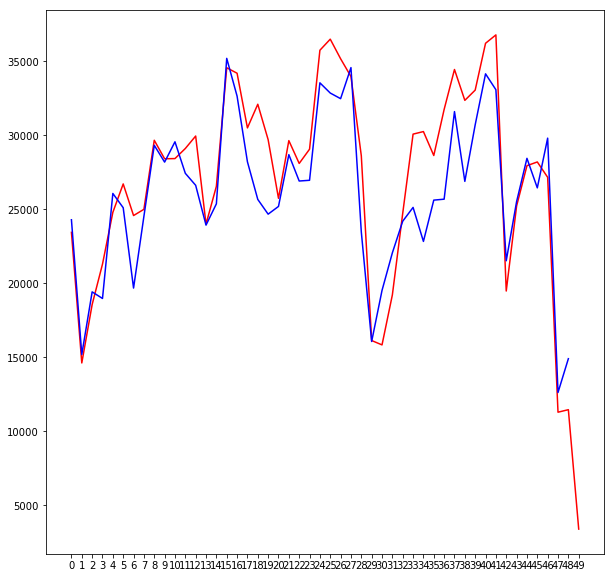

                    localhour air1 air2      air3 furnace1 furnace2  \
0      2013-03-23 08:00:00-05    0    0         0      5.9       10   
1      2013-03-23 09:00:00-05    0    0         0  4.91667       10   
2      2013-03-23 10:00:00-05    0    0         0      5.9  76.2833   
3      2013-03-23 11:00:00-05    0    0         0      5.9  76.0333   
4      2013-03-23 12:00:00-05    0    0         0        6       10   
5      2013-03-23 13:00:00-05    0    0         0        6       10   
6      2013-03-23 14:00:00-05    0    0         0        6       10   
7      2013-03-23 15:00:00-05    0    0         0        6       10   
8      2013-03-23 16:00:00-05    0    0         0        6       10   
9      2013-03-23 17:00:00-05    0    0         0        6       10   
10     2013-03-23 18:00:00-05    0    0         0        6       10   
11     2013-03-23 19:00:00-05    0    0         0  5.96667  10.1167   
12     2013-03-23 20:00:00-05    0    0         0     5.95       10   
13    

In [98]:
thermal_dict = {}
model_history = {}
local_scores=[]
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
print (df_new_thermal)

total_thermal_load
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
(1693, 7) (1693,)
                t-7          t-6          t-5          t-4          t-3  \
count   1693.000000  1694.000000  1695.000000  1696.000000  1697.000000   
unique  1691.000000  1692.000000  1693.000000  1694.000000  1695.000000   
top     1067.383333  1067.3833

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.647841826579
MSE :  12932142.1209
MAE :  2607.70988412


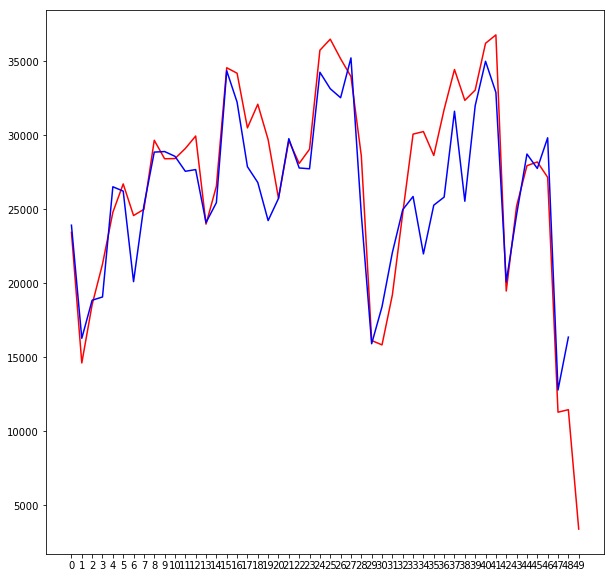

                    localhour air1 air2      air3 furnace1 furnace2  \
0      2013-03-23 08:00:00-05    0    0         0      5.9       10   
1      2013-03-23 09:00:00-05    0    0         0  4.91667       10   
2      2013-03-23 10:00:00-05    0    0         0      5.9  76.2833   
3      2013-03-23 11:00:00-05    0    0         0      5.9  76.0333   
4      2013-03-23 12:00:00-05    0    0         0        6       10   
5      2013-03-23 13:00:00-05    0    0         0        6       10   
6      2013-03-23 14:00:00-05    0    0         0        6       10   
7      2013-03-23 15:00:00-05    0    0         0        6       10   
8      2013-03-23 16:00:00-05    0    0         0        6       10   
9      2013-03-23 17:00:00-05    0    0         0        6       10   
10     2013-03-23 18:00:00-05    0    0         0        6       10   
11     2013-03-23 19:00:00-05    0    0         0  5.96667  10.1167   
12     2013-03-23 20:00:00-05    0    0         0     5.95       10   
13    

In [99]:
thermal_dict = {}
model_history = {}
local_scores=[]
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
print (df_new_thermal)

In [100]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16


total_thermal_load
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
(1693, 7) (1693,)
                t-7          t-6          t-5          t-4          t-3  \
count   1693.000000  1694.000000  1695.000000  1696.000000  1697.000000   
unique  1691.000000  1692.000000  1693.000000  1694.000000  1695.000000   
top     1067.383333  1067.3833

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.646837528077
MSE :  11931965.0217
MAE :  2532.08074704


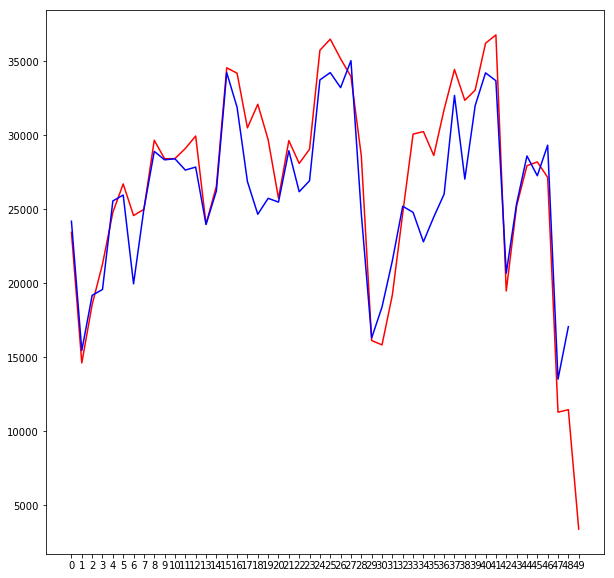

Time Taken :  1.1315784454345703
{'R2': 0.64683752807672024, 'MSE': 48525374.121808782, 'MAE': 4850.2538556430445}


In [101]:
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [106]:
print (r2_score(y_test1,y_pred1))

0.646837528077


In [107]:
#With the 'metric' as 'coefficient of determination (r^2)'.
'''
water-heater attribute is always negative when r^2 is used.
'''
thermal_dict1 = thermal_dict
print (thermal_dict1)


{'R2': 0.64683752807672024, 'MSE': 48525374.121808782, 'MAE': 4850.2538556430445}


In [108]:
#With the 'metric' as 'mean_squared_error'.
thermal_dict3 = thermal_dict
print (thermal_dict3)

{'R2': 0.64683752807672024, 'MSE': 48525374.121808782, 'MAE': 4850.2538556430445}


In [109]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_month(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(168), df.shift(24), df], axis=1)
                    ndf.columns = ('t-168', 't-24', 't')
                    ndf = ndf.iloc[168:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [110]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_2hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-2', 't-1', 't')
                    ndf = ndf.iloc[2:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [111]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_4hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(4),df.shift(3),df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-4','t-3','t-2', 't-1', 't')
                    ndf = ndf.iloc[4:]

                    x = ndf[ndf.columns[0:4]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]

                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [112]:
#Metric : 'r^2'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
[65664.763157168709, 30729.270134204569, 10347.59406247572, 37647.033278020543, 998.29458626169014, 38417.371994865716, 315441.01021544338]


In [113]:
#Metric : 'r^2'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
[64179.543748308344, 31174.264290511008, 10146.549583791384, 42430.600607376786, 1039.7521256057755, 37506.195334307013, 314660.11417068739]


In [114]:
#Metric : 'r^2'.
scores_month = et_month(df_thermal)
print (scores_month)

(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
[103628.7907357698, 51561.39344281052, 31148.040947090645, 110357.90134009351, 1770.8464882859787, 41303.416673699096, 537612.36188027484]


In [115]:
#Metric : 'mse'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
[66329.405505932998, 31472.689678848754, 11133.566424424267, 34212.575054481844, 1051.3436233956415, 36453.796057969339, 317080.16818584083]


In [116]:
#Metric : 'mse'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
[63113.508874811589, 32303.212822949346, 9330.866794732563, 43717.074093591895, 1067.2330125890071, 37286.649639767427, 300314.38493312511]


In [117]:
df_thermal.head(10)

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16
5,2013-03-23 13:00:00-05,0,0,0,6,10,0,16
6,2013-03-23 14:00:00-05,0,0,0,6,10,0,16
7,2013-03-23 15:00:00-05,0,0,0,6,10,0,16
8,2013-03-23 16:00:00-05,0,0,0,6,10,0,16
9,2013-03-23 17:00:00-05,0,0,0,6,10,0,16


In [118]:
df_thermal.to_csv("df_thermal.csv",encoding="utf8")

In [119]:
for i in df_thermal.columns:
    print (np.amax(df_thermal[i]))

2017-11-18 02:00:00-06
2399.916666666667
1925.0166666666669
1573.7333333333331
5048.083333333333
1020.6999999999999
1966.583333333333
6313.65


In [120]:
df_thermal.shape

(40820, 8)

In [121]:
df_thermal.tail(10)

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
40810,2017-11-17 17:00:00-06,0,0,0,5,5,0,10
40811,2017-11-17 18:00:00-06,0,0,0,5,5,0,10
40812,2017-11-17 19:00:00-06,0,0,0,5,5,0,10
40813,2017-11-17 20:00:00-06,0,0,0,5,5,0,10
40814,2017-11-17 21:00:00-06,0,0,0.55,5.15,5,415.017,425.717
40815,2017-11-17 22:00:00-06,0,0,0,5,5,0,10
40816,2017-11-17 23:00:00-06,0,0,0,5,5,0,10
40817,2017-11-18 00:00:00-06,0,0,0,5,5,0,10
40818,2017-11-18 01:00:00-06,0,0,0,5,5,0,10
40819,2017-11-18 02:00:00-06,0,0,0,5,5,0,10


In [122]:
days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
columns = np.empty([df_thermal.shape[0],1],dtype=str)
i=0
while i <= (df_thermal.shape[0]-7):
    columns[i]   = 'Saturday'
    columns[i+1] = 'Sunday'
    columns[i+2] = 'Monday'
    columns[i+3] = 'Tuesday'
    columns[i+4] = 'Wednesday'
    columns[i+5] = 'Thursday'
    columns[i+6] = 'Friday'
    i += 7

In [123]:
print (columns[0])

['S']


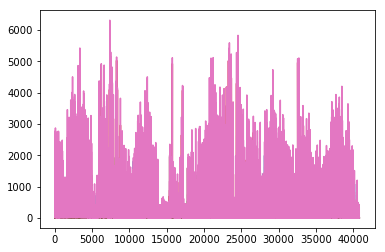

In [124]:
plt.plot(df_thermal.values[:,1:])
plt.show()

In [129]:
for i in range(df_thermal.columns.shape[0]):    
    print ("\nMAX,MIN: ",np.max(df_thermal.values[:,i])," ",np.min(df_thermal.values[:,i]) )


MAX,MIN:  2017-11-18 02:00:00-06   2013-03-23 08:00:00-05

MAX,MIN:  2399.916666666667   0.0

MAX,MIN:  1925.0166666666669   0.0

MAX,MIN:  1573.7333333333331   0.0

MAX,MIN:  5048.083333333333   0.0

MAX,MIN:  1020.6999999999999   0.0

MAX,MIN:  1966.583333333333   0.0

MAX,MIN:  6313.65   0.0


In [131]:
df_thermal.values[:,4:6]

array([[5.8999999999999995, 10.0],
       [4.916666666666666, 10.0],
       [5.8999999999999995, 76.28333333333333],
       ..., 
       [5.0, 5.0],
       [5.0, 5.0],
       [5.0, 5.0]], dtype=object)